In [1]:
!pip install hdbscan
!pip install geopandas
!pip install contextily
!pip install shapely

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.preprocessing import StandardScaler

import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

import warnings
warnings.filterwarnings("ignore")

### Download the Canada map for reference

In [3]:
import requests
import io
import zipfile

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip"
with zipfile.ZipFile(io.BytesIO(requests.get(url).content)) as z:
    for name in z.namelist():
        if name.endswith(".tif"):
            z.extract(name)
            print(f"Downloaded and extracted: {name}")

Downloaded and extracted: Canada.tif


### Include a plotting function

In [4]:
def plot_clustered_locations(df, title="Museums Clustered by Proximity"):
    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")
    gdf = gdf.to_crs(epsg=3857) # Convert to Web Mercator for basemap alignment

    # Split into noise and clustered points
    noise = gdf[gdf.Cluster == -1]
    clustered = gdf[gdf.Cluster != 1]

    # Create plot
    fig, ax = plt.subplots(figsize=(14,7))
    noise.plot(ax=ax, color="k", ec="r", alpha=1, label="Noise", markersize=30)
    clustered.plot(ax=ax, column="Cluster", cmap="tab10", ec="k", alpha=0.6, markersize=30)

    # Add basemap
    ctx.add_basemap(ax, source='./Canada.tif', zoom=4)

    ax.set_title(title)
    ax.set_xticks([]), ax.set_yticks([])
    plt.xlabel("Longitude"), plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()

### Explore the data and extract

In [5]:
url = "F:\Data_Science_Jupyter_Files\ODCAF_v1.0.csv"
df = pd.read_csv(url, encoding= "ISO-8859-1")

In [6]:
df.head()

,Index,Facility_Name,Source_Facility_Type,ODCAF_Facility_Type,Provider,Unit,Street_No,Street_Name,Postal_Code,City,Prov_Terr,Source_Format_Address,CSD_Name,CSDUID,PRUID,Latitude,Longitude
0,1,#Hashtag Gallery,..,gallery,toronto,..,801,dundas st w,M6J 1V2,toronto,on,801 dundas st w,Toronto,3520005,35,43.65169472,-79.40803272
1,2,'Ksan Historical Village & Museum,historic site-building or park,museum,canadian museums association,..,1500,62 hwy,V0J 1Y0,hazelton,bc,1500 hwy 62 hazelton british columbia v0j 1y0 ...,Hazelton,5949022,59,55.2645508,-127.6428124
2,3,'School Days' Museum,community/regional museum,museum,canadian museums association,..,427,queen st,E3B 5R6,fredericton,nb,427 queen st fredericton new brunswick e3b 5r6...,Fredericton,1310032,13,45.963283,-66.6419017
3,4,10 Austin Street,built heritage properties,heritage or historic site,moncton,..,10,austin st,E1C 1Z6,moncton,nb,10 austin st,Moncton,1307022,13,46.09247776,-64.78022946
4,5,10 Gates Dancing Inc.,arts,miscellaneous,ottawa,..,..,..,..,ottawa,on,..,Ottawa,3506008,35,45.40856224,-75.71536766


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7972 entries, 0 to 7971
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Index                  7972 non-null   int64 
 1   Facility_Name          7972 non-null   object
 2   Source_Facility_Type   7972 non-null   object
 3   ODCAF_Facility_Type    7972 non-null   object
 4   Provider               7972 non-null   object
 5   Unit                   7972 non-null   object
 6   Street_No              7972 non-null   object
 7   Street_Name            7972 non-null   object
 8   Postal_Code            7972 non-null   object
 9   City                   7972 non-null   object
 10  Prov_Terr              7972 non-null   object
 11  Source_Format_Address  7972 non-null   object
 12  CSD_Name               7972 non-null   object
 13  CSDUID                 7972 non-null   object
 14  PRUID                  7972 non-null   object
 15  Latitude             

In [8]:
df.isnull().sum()

Index                    0
Facility_Name            0
Source_Facility_Type     0
ODCAF_Facility_Type      0
Provider                 0
Unit                     0
Street_No                0
Street_Name              0
Postal_Code              0
City                     0
Prov_Terr                0
Source_Format_Address    0
CSD_Name                 0
CSDUID                   0
PRUID                    0
Latitude                 0
Longitude                0
dtype: int64

In [9]:
# Filter the data to only include museums.
df = df[df.ODCAF_Facility_Type == "museum"]
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
museum    1938
Name: count, dtype: int64

In [10]:
# Select only the Latitude and Longitude features as inputs to our clustering problem.
df = df[["Latitude", "Longitude"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   1938 non-null   object
 1   Longitude  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


In [11]:
df = df[df.Latitude!=".."]
df[["Latitude", "Longitude"]] = df[["Latitude", "Longitude"]].astype("float")

### Build a DBSCAN model
#### Correctly scale the coordinates for DBSCAN (since DBSCAN is sensitive to scale)

In [12]:
coords_scaled = df.copy()
coords_scaled["Latitude"] = 2*coords_scaled["Latitude"]

#### Apply DBSCAN with Euclidean distance to the scaled coordinates

In [13]:
min_samples = 3  # minimum number of samples needed to form a neighbourhood
eps = 1.0  # neighbourhood search radius
metric = "euclidean"  # distance measure 

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(coords_scaled)

#### Add cluster labels to the DataFrame

In [14]:
df["Cluster"] = dbscan.fit_predict(coords_scaled)
df["Cluster"].value_counts()

Cluster
 4     701
 2     192
 1     181
 7     134
 3      94
-1      79
 6      30
 10     27
 8      21
 11     15
 15     13
 20     11
 16     10
 19      9
 27      8
 12      7
 26      6
 5       6
 24      6
 28      6
 14      6
 18      6
 13      4
 9       4
 22      4
 0       3
 23      3
 21      3
 17      3
 25      3
 29      3
 31      3
 30      3
 32      3
Name: count, dtype: int64

#### Plot the museums on a basemap of Canada, colored by cluster label.

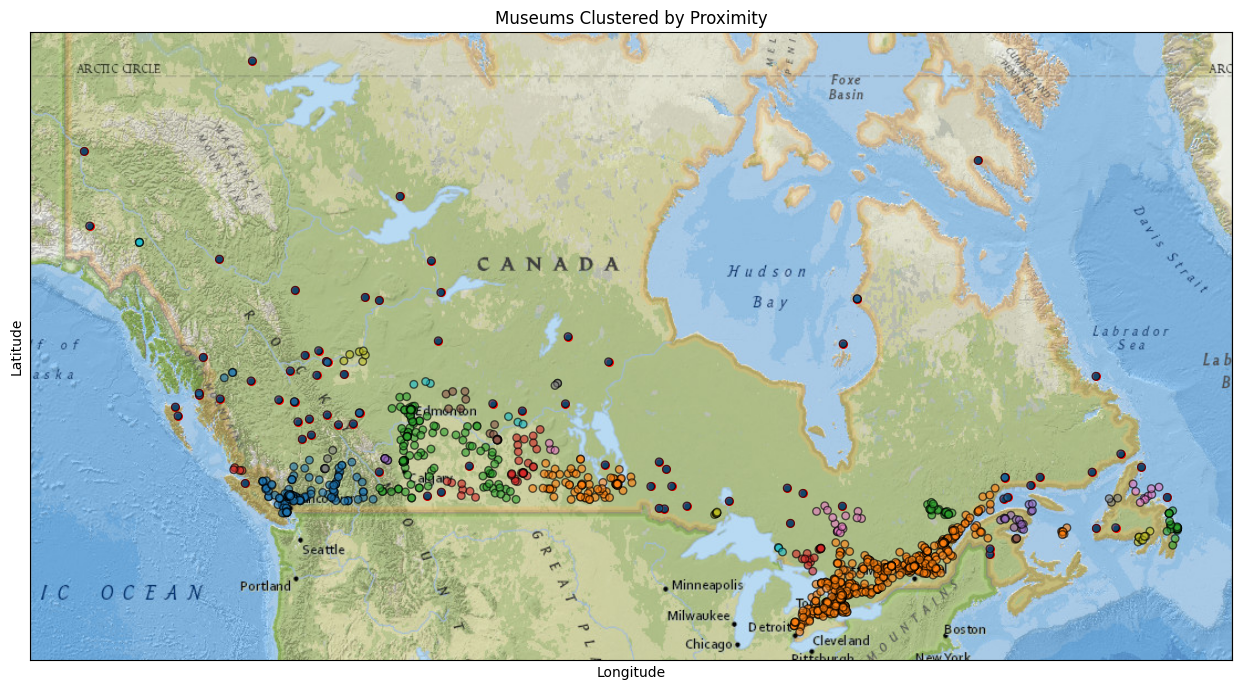

In [15]:
plot_clustered_locations(df, title="Museums Clustered by Proximity")

### Build an HDBSCAN clustering model

#### Initialize an HDBSCAN model

In [16]:
min_samples = None
min_cluster_size = 3
hdb = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric="euclidean")

In [18]:
# Assign the cluster labels to your unscaled coordinate dataframe and display the counts of each cluster label.

# Assign labels
df["Cluster"] = hdb.fit_predict(coords_scaled)

# Display the size of each cluster
df["Cluster"].value_counts()

Cluster
-1      454
 137     44
 97      39
 58      35
 93      33
       ... 
 133      3
 39       3
 69       3
 47       3
 132      3
Name: count, Length: 141, dtype: int64

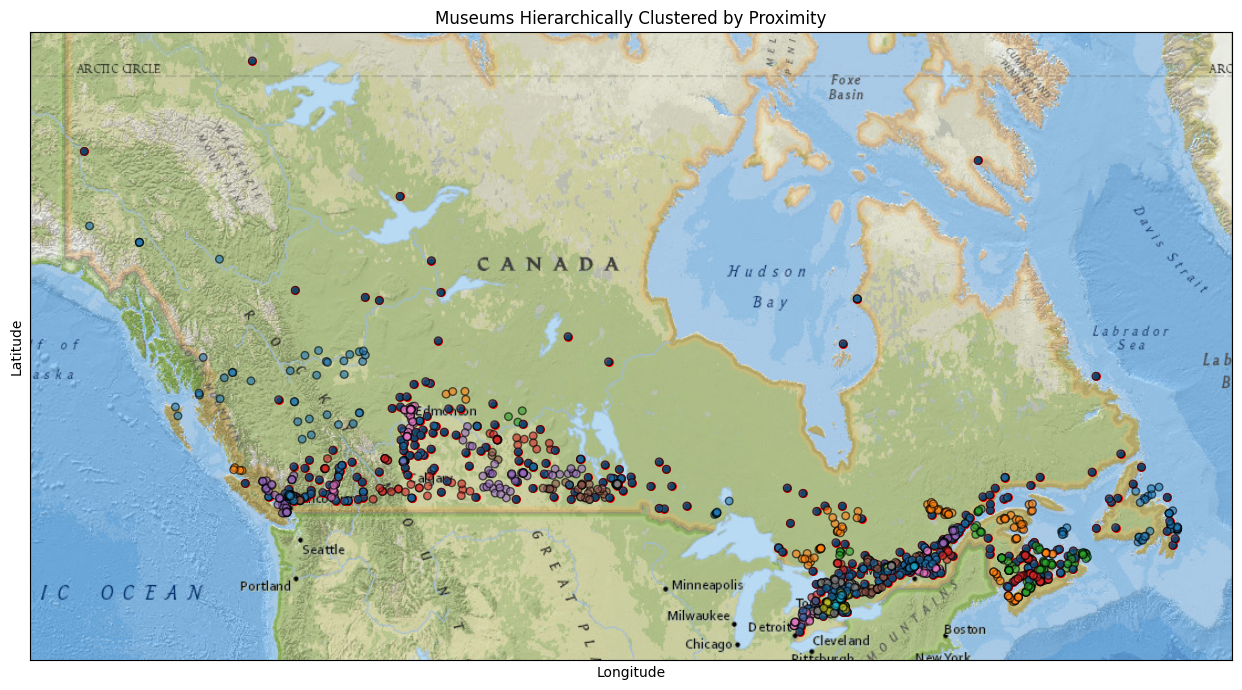

In [19]:
# Plot the hierarchically clustered museums on a basemap of Canada, colored by cluster label.

plot_clustered_locations(df, title='Museums Hierarchically Clustered by Proximity')